# Name Generator

In [2]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import warnings
import matplotlib.pyplot as plt

First, let's set some path usefult in this application

In [3]:
PRJ_PATH = '.'
DATA_PATH = os.path.join(PRJ_PATH, 'data', 'names.txt')
MODEL_FLD = os.path.join(PRJ_PATH, 'model')

print(f'Path containing all names: {DATA_PATH}')
print(f'Folder that contains the saved network: {MODEL_FLD}')

Path containing all names: .\data\names.txt
Folder that contains the saved network: .\model


We need to create 2 simple dictionaries that maps an integer to a letter and vice versa

char2int : char -> integer <br />
int2char : integer -> char

In [4]:
char2int = {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7,
            'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14,
            'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21,
            'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
int2char = inv_map = {v: k for k, v in char2int.items()}

In [5]:
# Creating the folder where the model will be saved
if 'model' not in os.listdir(PRJ_PATH):
    os.makedirs(os.path.join(PRJ_PATH, 'model'))

## Dataset

In [6]:
# Loading the file containing the names and prepocessing them
with open(DATA_PATH, 'r') as f:
    names = f.readlines()
    names = [s.strip().lower() for s in names]

print('First 10 names:')
print('\t'.join(names[:5]))
print('\t'.join(names[5:10]))

First 10 names:
brycen	oakley	isabel	estella	enoch
natasha	brynn	jayde	kyla	sophie


In [12]:
class NameDatataset(Dataset):
    def __init__(self, names=None):
        # Names
        self.names = names

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        # Fix the length to 11
        x_str = (self.names[idx].lower() + '.'*11)[:11]
        # Create the expected output for x_str
        y_str = x_str[1:] + "."

        x = torch.zeros((11, 27))
        y = torch.zeros(11)
        for i, c in enumerate(x_str):
            # Perform one-hot-encoding of each symbol
            x[i, char2int[c]] = 1
        for i, c in enumerate(y_str):
            y[i] = char2int[c]

        return x, y

## Model

In [13]:
INPUT_SIZE = 27
HIDDEN_SIZE = 216
OUTPUT_SIZE = 27
NUM_LAYERS = 2

In [14]:
class Lstm(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Lstm, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm1 = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Fully connected layers
        self.fc1 = torch.nn.Linear(hidden_size, int(round(hidden_size/2, 0)))
        self.fc2 = torch.nn.Linear(int(round(hidden_size/2, 0)), output_size)

    def forward(self, X, states):
        ht, ct = states
        # LSTM
        out, (ht, ct) = self.lstm1(X, (ht, ct))

        # First FC layer
        out = self.fc1(out)
        out = F.relu(out)

        # Second FC layer
        out = self.fc2(out)

        return out, (ht, ct)

## Training

In [15]:
np.random.seed(1)
torch.manual_seed(1)
warnings.filterwarnings("ignore", category=UserWarning)

In [16]:
BATCH_SIZE = 1
LEARNING_RATE = 0.005
GAMMA = 0.95
NUM_EPOCHS = 200

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training on ' + ("cuda:0" if torch.cuda.is_available() else "cpu"))

Training on cuda:0


In [19]:
# Let's instantiate the Dataset
dataset = NameDatataset(names)
# Let's instantiate the Loader
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

In [20]:
# Instantiate the network
model = Lstm(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS).to(device)
# Instantiate the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Instantiate the loss function
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
# Instantiate the learning rate scheduler
sched = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=GAMMA)

In [ ]:
losses = []
for epoch in range(NUM_EPOCHS):
    model.train()

    batch_loss = 0

    h0 = torch.zeros((NUM_LAYERS, 1, HIDDEN_SIZE)).to(device)
    c0 = torch.zeros((NUM_LAYERS, 1, HIDDEN_SIZE)).to(device)
    for batch_id, (data, label) in enumerate(loader):
        h, c = h0.detach().clone(), c0.detach().clone()

        # First, push on the GPU all the tensors
        data, label = data.to(device), label.to(device, dtype=torch.long)
        # Empty the gradient
        optimizer.zero_grad()
        # Get the output from the network
        out, (h, c) = model(data, (h, c))
        out = out.transpose(1, 2)
        # Calculate the loss
        loss = loss_fn(out, label)
        # Perform the backpropagation
        loss.backward()
        # Perform the gradient descent
        optimizer.step()

        # Record the loss
        batch_loss += loss.item()

    tot_loss = batch_loss / len(loader)
    print(f'Epoch {epoch} -> ' +
          f'Loss = {tot_loss:.6f}')

    losses.append(tot_loss)
    sched.step()

In [22]:
torch.save(model.state_dict(), os.path.join(MODEL_FLD, 'net.pt'))
print(f'Saved model in {MODEL_FLD}')

Saved model in .\model


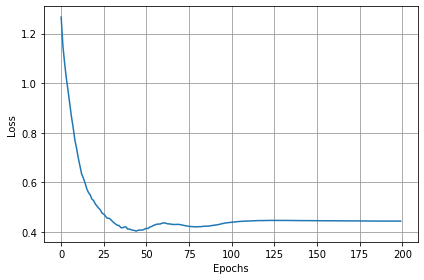

In [24]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(color="#989898", zorder=0)

plt.plot(list(range(len(losses))), losses, zorder=3)

plt.tight_layout()
plt.show()

## Generator

In [50]:
# Used to create a tensor that represents the word passed as argument
def word2tensor(word, max_name_len):
    w = torch.zeros((11, 27))
    for i in range(len(word)):
        w[i, char2int[word[i]]] = 1
    for i in range(len(word), max_name_len):
        w[i, 0] = 1
    return torch.unsqueeze(w, 0)

In [51]:
MAX_NAME_LEN = 11
TOP_K_OPTIONS = 3
NUM_NAMES = 20

In [52]:
# Set the first letter of the kind of name that you want generate
NAMES_FIRST_LETTER = ['a', 'f']

In [53]:
model.eval()

h0 = torch.zeros((NUM_LAYERS, 1, HIDDEN_SIZE)).to(device)
c0 = torch.zeros((NUM_LAYERS, 1, HIDDEN_SIZE)).to(device)

names = []

for letter in NAMES_FIRST_LETTER:
    current_names = []
    for _ in range(NUM_NAMES):
        name = letter

        with torch.no_grad():
            for idx in range(MAX_NAME_LEN):
                # If last letter is the "end" character, terminate the generation
                if name[-1] == '.': break

                # Generate the tensor representing the name (till the last letter generated)
                data = word2tensor(name, MAX_NAME_LEN).to(device)

                # Generate new letter for the name
                h, c = h0.detach().clone(), c0.detach().clone()
                out, (h, c) = model(data, (h, c))

                # Select the top-k generated letters
                out = torch.squeeze(out, dim=0)
                out = out[idx]
                top_k_val, top_k_idx = torch.topk(out, TOP_K_OPTIONS)
                top_k_idx = top_k_idx.cpu().numpy()

                # From the top-k select with special distribution which is the next letter
                # This is done to avoid having completely a deterministic name generation process
                selector = np.random.rand()
                if   selector >= 0.5:   choice = 0
                elif selector >= 0.2:   choice = 1
                else:                   choice = 2

                # Appen to the name the new letter (or "end" character)
                last_letter = int2char[top_k_idx[choice]]
                if last_letter != ".": name += last_letter
                else:
                    if idx > 2: name += last_letter

        if name[-1] == '.': name = name[:-1]
        current_names.append(name)

    names.append((letter, current_names))
print('Name generated!')

Name generated!


In [54]:
for letter, names_list in names:
    print(f'Names generated with starting letter "{letter}":\n')

    for curr_idx in range(0, NUM_NAMES-5, 5):
        final_str = ''
        for idx in range(curr_idx, curr_idx+5):
            final_str += names_list[idx] + ' '*(15-len(names_list[idx]))
        print(final_str)
    print('\n-------------------------------------------------------------------------\n')

Names generated with starting letter "a":

alexa          anablee        anas           alexandriah    alessan        
arya           ares           aleja          alexan         alex           
aleso          annaballa      ana            alinah         annabel        

-------------------------------------------------------------------------

Names generated with starting letter "f":

farroyi        frarandol      frances        franco         frarin         
frane          fishe          finnegenle     farbana        frediet        
finnegan       fishel         fridahna       faita          farro          

-------------------------------------------------------------------------

